# Applied Machine Learning: In-class Exercise 01-4

## Goal

The goal for this exercise is to familiarize yourself with two very important machine learning methods, the decision tree and random forest. After this exercise, you should be able to train these models and extract important information to understand the model internals.

## Exercises

### Fit a decision tree

Use the German Credit dataset (`fetch_openml("credit-g", version=1, as_frame=True)`) to create the classification task. Transform categorical features appropriately by creating dummy variables (`pd.get_dummies(X, drop_first=True)`), and then train a decision tree classifier (`DecisionTreeClassifier`) using scikit-learn with a maximum depth of 5. After training, inspect the trained decision tree's structure by exporting and viewing its textual representation (`export_text`).

<details><summary>Hint 1:</summary>
For this exercise, use default hyperparameters except for `max_depth=5`, otherwise the visualization in the next exercise will be cluttered.
</details>

In [1]:
#===SOLUTION===

import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.tree import DecisionTreeClassifier, export_text

rng = np.random.default_rng(seed=42)

X, y = fetch_openml("credit-g", version=1, as_frame=True, return_X_y=True)

X = pd.get_dummies(X, drop_first=True)

# Here we choose max_depth=5 instead of max_depth=None, so that the visualization latter is not too cluttered.
clf = DecisionTreeClassifier(max_depth=5, random_state=42)
clf.fit(X, y)

tree_rules = export_text(clf, feature_names=list(X.columns))
print(f"Trained decision tree classifier:\n{tree_rules}")

Trained decision tree classifier:
|--- checking_status_no checking <= 0.50
|   |--- duration <= 22.50
|   |   |--- property_magnitude_no known property <= 0.50
|   |   |   |--- duration <= 11.50
|   |   |   |   |--- age <= 34.50
|   |   |   |   |   |--- class: good
|   |   |   |   |--- age >  34.50
|   |   |   |   |   |--- class: good
|   |   |   |--- duration >  11.50
|   |   |   |   |--- credit_amount <= 1285.50
|   |   |   |   |   |--- class: bad
|   |   |   |   |--- credit_amount >  1285.50
|   |   |   |   |   |--- class: good
|   |   |--- property_magnitude_no known property >  0.50
|   |   |   |--- credit_history_critical/other existing credit <= 0.50
|   |   |   |   |--- employment_unemployed <= 0.50
|   |   |   |   |   |--- class: bad
|   |   |   |   |--- employment_unemployed >  0.50
|   |   |   |   |   |--- class: good
|   |   |   |--- credit_history_critical/other existing credit >  0.50
|   |   |   |   |--- credit_amount <= 1375.50
|   |   |   |   |   |--- class: bad
|   | 

### Visualize the tree structure

To interpret the model and gain more insights into its decision-making process, visualize the trained decision tree using scikit-learn. Limit the depth or adjust visualization parameters (such as node proportion and precision) to reduce visual clutter and improve interpretability.

<details><summary>Hint 1:</summary>
Use `sklearn.tree.plot_tree` to visualize the trained decision tree. You can customize visualization options like `filled=True` to add colors and `rounded=True` for better aesthetics.
</details>

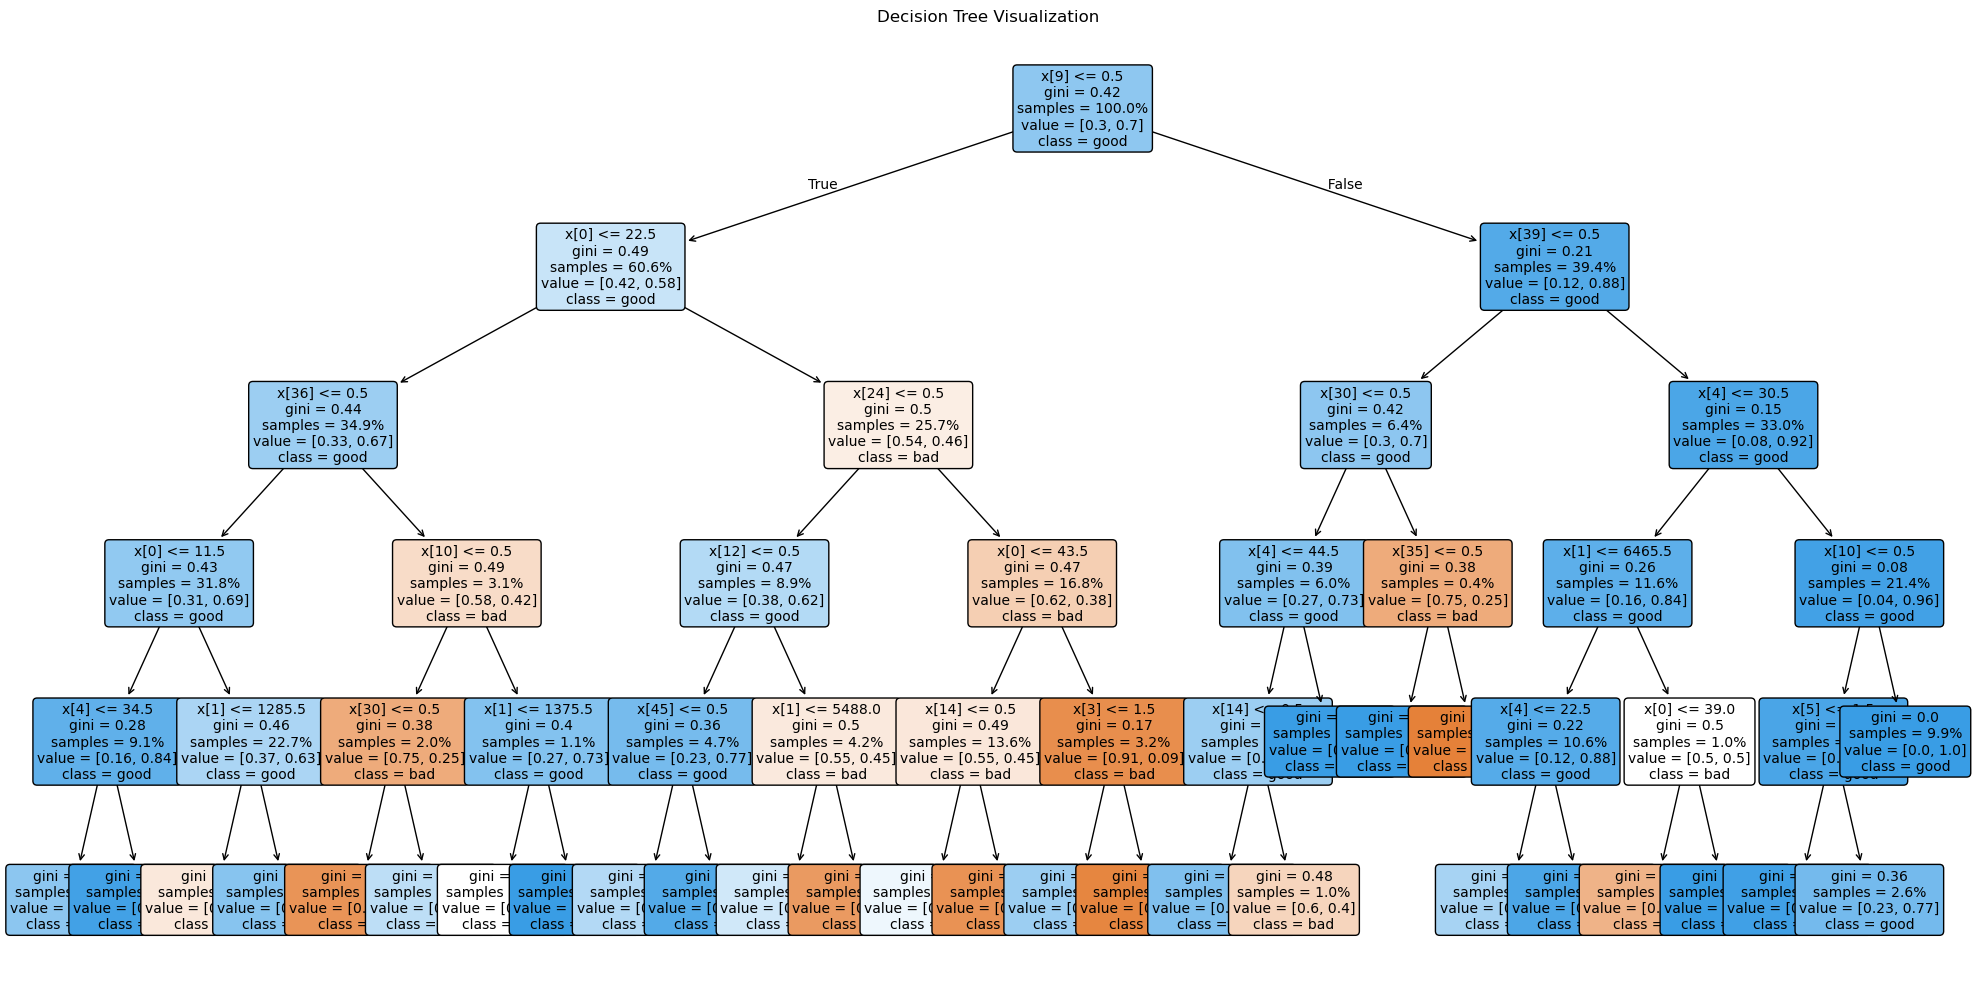

In [2]:
#===SOLUTION===

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree


plt.figure(figsize=(20, 10))
# you can also pass feature_names=X.columns to better annotate the internal nodes
# but it would be very cluttered in the current case, because the feature names are very long
plot_tree(clf, 
          class_names=clf.classes_,
          filled=True, 
          rounded=True,
          fontsize=10,  
          proportion=True, 
          precision=2) 
plt.title("Decision Tree Visualization")
plt.tight_layout()
plt.show()

## Fit a random forest

To obtain a more powerful learner, we will also train a random forest classifier. Using scikit-learn, fit a random forest (`RandomForestClassifier`) with default hyperparameters and a maximum depth of 5 on the German Credit dataset.

<details><summary>Reminder:</summary>
One of the drawbacks of using trees is the instability of the predictor. Small changes in the data may lead to very different models and, consequently, high variance in predictions. The random forest method addresses this issue by reducing variance through bagging of multiple decision trees.
</details>

<details><summary>Hint 1:</summary>
In scikit-learn, use `RandomForestClassifier` from the `ensemble` module to fit the random forest.
</details>

In [3]:
#===SOLUTION===

from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X, y)

RandomForestClassifier(random_state=42)

## ROC Analysis

The bank wants to use a tree-based model to predict credit risk. Conduct a simple benchmark to determine whether a decision tree or a random forest performs better for this purpose. Specifically, the bank requires that among credit applications predicted as "good," no more than 10% should actually be "bad" (i.e., precision ≥ 90%). Additionally, the bank aims to correctly classify at least 90% of all genuinely "good" applications (i.e., recall ≥ 90%).

Evaluate the performance of both the decision tree and random forest using cross-validation. Visualize the results using precision-recall curves, clearly indicating the 90% precision and recall thresholds. 

<details><summary>Hint 1:</summary>
Use precision-recall curves (`precision_recall_curve`) with cross-validation to compare the models. Include horizontal and vertical reference lines at the 90% thresholds.
</details>

<details><summary>Hint 2:</summary>
Use `plt.fill_between()` to create a shaded region to inidicate the +/- 1x standard deviation of the precision-recall curves derived from the cross-valdiation models.
</details>


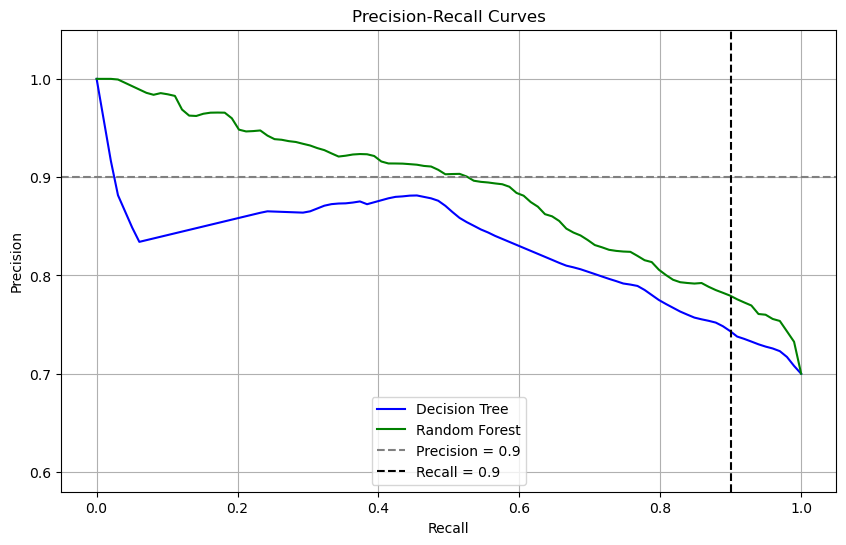

In [4]:
#===SOLUTION===

import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, BaseCrossValidator
from sklearn.metrics import precision_recall_curve
from sklearn.base import BaseEstimator, clone
from typing import Tuple, List, Union


cv = KFold(n_splits=5, shuffle=True, random_state=42)


def evaluate_model_with_cv(
    model: BaseEstimator, 
    X: Union[np.ndarray, pd.DataFrame], 
    y: Union[np.ndarray, pd.Series], 
    cv: BaseCrossValidator
) -> Tuple[List[np.ndarray], List[np.ndarray]]:
    """Evaluate a model using cross-validation and return precision-recall metrics for each fold.
    
    Args:
        model: The model to evaluate (must have predict_proba method)
        X: Feature matrix
        y: Original target labels
        cv: Cross-validation splitter
        
    Returns:
        tuple: Contains:
            - precisions (List[np.ndarray]): Precision values for each fold
            - recalls (List[np.ndarray]): Recall values for each fold
    """
    precisions = []
    recalls = []
    y_probs = []
    y_bin_all = []
    
    # For each fold
    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        # Train the model
        model_clone = clone(model)
        model_clone.fit(X_train, y_train)
        
        # Predict probabilities
        probs = model_clone.predict_proba(X_test)
        pos_index = list(model_clone.classes_).index("good")
        y_prob = probs[:, pos_index]
        y_probs.extend(y_prob)
        
        # Binarize the target for this fold
        y_bin_test = (y_test == "good").astype(int)
        y_bin_all.extend(y_bin_test)
        
        # Calculate precision-recall curve for this fold
        precision, recall, _ = precision_recall_curve(y_bin_test, y_prob, pos_label=1)
        precisions.append(precision)
        recalls.append(recall)
    
    return precisions, recalls

def interpolate_precision_recall(
        precisions: List[np.ndarray], 
        recalls: List[np.ndarray], 
        num_points: int = 100
) -> Tuple[np.ndarray, np.ndarray]:
    """Interpolate precision-recall curves to a common set of recall points."""
    # Create a common set of recall points
    common_recalls = np.linspace(0, 1, num_points)
    interpolated_precisions = []
    
    for precision, recall in zip(precisions, recalls):
        # Ensure recall is in ascending order for interpolation
        if len(recall) > 1:
            # Interpolate precision at common recall points
            interpolated_precision = np.interp(common_recalls, recall[::-1], precision[::-1])
            interpolated_precisions.append(interpolated_precision)
    
    # Convert to numpy array for easier calculations
    interpolated_precisions = np.array(interpolated_precisions)
    
    # Calculate mean of precision at each recall point
    mean_precision = np.mean(interpolated_precisions, axis=0)
    
    return mean_precision, common_recalls


# Evaluate Decision Tree
dt_precisions, dt_recalls = evaluate_model_with_cv(clf, X, y, cv)
dt_mean_precision, dt_common_recalls = interpolate_precision_recall(dt_precisions, dt_recalls)

# Evaluate Random Forest
rf_precisions, rf_recalls = evaluate_model_with_cv(rf_clf, X, y, cv)
rf_mean_precision, rf_common_recalls = interpolate_precision_recall(rf_precisions, rf_recalls)

plt.figure(figsize=(10, 6))

# Plot Decision Tree PR curve
plt.plot(dt_common_recalls, dt_mean_precision, label=f"Decision Tree", color='blue')

# Plot Random Forest PR curve
plt.plot(rf_common_recalls, rf_mean_precision, label=f"Random Forest", color='green')

# Plot reference lines for 90% precision and 90% recall
plt.axhline(y=0.9, color='grey', linestyle='--', label="Precision = 0.9")
plt.axvline(x=0.9, color='black', linestyle='--', label="Recall = 0.9")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim(0.58, 1.05)
plt.title("Precision-Recall Curves")
plt.legend(loc="lower center")
plt.grid(True)
plt.show()


Based on your visualization, discuss:

- Which model better meets the bank's requirements?
- Can the bank expect either model to fulfill its requirements?

===SOLUTION===

While the random forest dominates the decision tree, neither model can fulfil the bank’s requirement of a precision and recall of >90%.

## Understand hyperparameters

Use the German Credit dataset to create a classification task. In this exercise, you will fit decision trees and random forests with varying hyperparameter settings, as these can significantly impact model performance. Both learners—decision trees (`DecisionTreeClassifier`) and random forests (`RandomForestClassifier`)—offer several hyperparameters that influence model behavior during training.

Focus on parameters `max_depth` and `max_features`.

According to the [Docs of `sklearn.tree.DecisionClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html):
> `max_depth int, default=None`: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

> `max_features int, float or {“sqrt”, “log2”}, default=None`: The number of features to consider when looking for the best split:
> If int, then consider `max_features` features at each split.
> If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.
> If “sqrt”, then `max_features=sqrt(n_features)`.
> If “log2”, then `max_features=log2(n_features)`.
> If None, then `max_features=n_features`.

Focus on the following:
- For decision trees, vary the `max_depth` parameter, which controls how deep the tree can grow.
- For random forests, vary the `max_features` parameter, which determines the number of features considered when looking for the best split at each node.

Your task is to manually create several decision tree and random forest classifiers using different values for these hyperparameters. In the next step, you will compare their performance.

<details><summary>Hint 1:</summary>
Use a dict of {"model name": model instance} to store the models to facilitate the benchmarking in the next exercise.
</details>

In [5]:
#===SOLUTION===

from sklearn.ensemble import RandomForestClassifier

# Define configurations for models
dt_configs = [
    ("Decision Tree (max_depth=1)", {"max_depth": 1}),
    ("Decision Tree (max_depth=5)", {"max_depth": 5}),
    ("Decision Tree (max_depth=20)", {"max_depth": 20})
]

rf_configs = [
    ("Random Forest (max_features=0.2)", {"max_features": 0.2}),
    ("Random Forest (max_features=0.5)", {"max_features": 0.5}),
    ("Random Forest (max_features=0.8)", {"max_features": 0.8})
]

# Create a dictionary to store models
learners = {}

# Create Decision Tree models
for name, params in dt_configs:
    params["random_state"] = 31415
    # Note: we set criterion to "entropy" to better demonstrate the sensitivity of the model to the choice of hyperparameters.
    # We also tried other criteria, but under other criteria, the model performance difference is not significant to observe.
    # We also fix max_features to 0.8 while ablating max_depth, and vice versa.
    learners[name] = DecisionTreeClassifier(criterion="entropy", max_features=0.8, **params)

# Create Random Forest models
# In sklearn, max_features accepts a fraction which is analogous to mtry.ratio in ranger.
for name, params in rf_configs:
    params["random_state"] = 31415
    learners[name] = RandomForestClassifier(criterion="entropy", max_depth=5, **params)


## Comparison of trees and random forests

Does model performance vary depending on the chosen hyperparameters? Use the decision tree and random forest models created in the previous exercise to conduct a benchmark. Evaluate each model using 5-fold cross-validation and use accuracy as the performance metric. Visualize the results to compare how different hyperparameter settings affect the models' predictive performance (use classification error as the metric in the visualization).

<details><summary>Hint 1:</summary>
Use `cross_val_score` with `scoring='accuracy'` and compute classification error as `1 - accuracy`.
</details>

<details><summary>Hint 2:</summary>
Create a boxplot (`plt.boxplot`) to visualize the distribution of classification errors across folds for each model configuration.
</details>

Decision Tree (max_depth=1) errors: [0.35  0.285 0.335 0.3   0.285]
Decision Tree (max_depth=5) errors: [0.285 0.29  0.28  0.305 0.305]
Decision Tree (max_depth=20) errors: [0.32  0.325 0.305 0.33  0.335]
Random Forest (max_features=0.2) errors: [0.24  0.22  0.295 0.295 0.25 ]
Random Forest (max_features=0.5) errors: [0.21  0.215 0.3   0.28  0.22 ]
Random Forest (max_features=0.8) errors: [0.24  0.225 0.29  0.26  0.24 ]


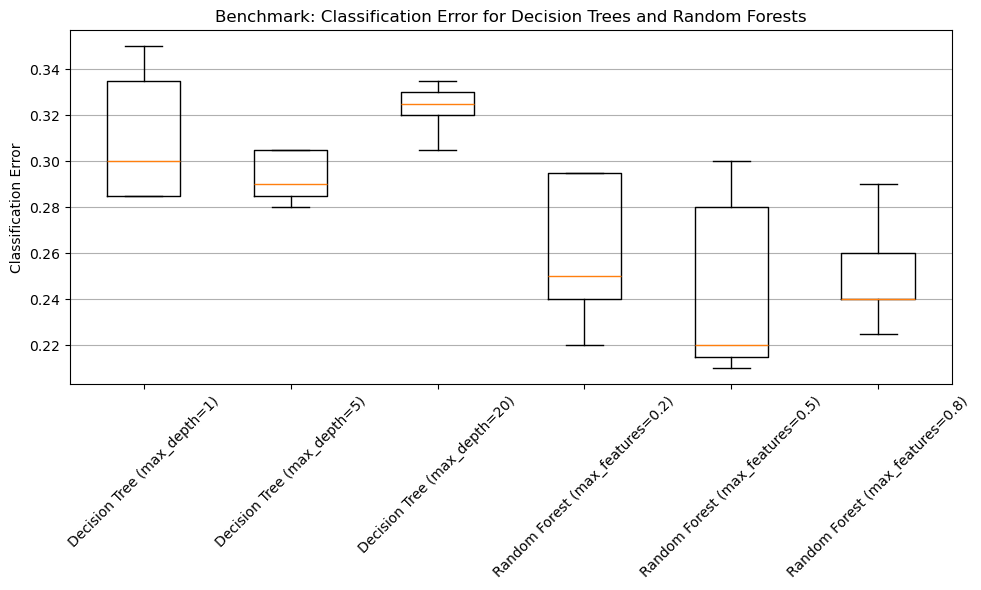

In [6]:
from sklearn.model_selection import cross_val_score, KFold

cv = KFold(n_splits=5, shuffle=True, random_state=31415)

results = {}

for name, model in learners.items():
    # Compute 5-fold accuracy scores
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    # Convert accuracy scores to classification error
    errors = 1 - scores
    results[name] = errors
    print(f"{name} errors: {errors}")

labels = list(results.keys())
boxplot_data = [results[label] for label in labels]

plt.figure(figsize=(10, 6))
plt.boxplot(boxplot_data, labels=labels)
plt.xticks(rotation=45)
plt.ylabel("Classification Error")
plt.grid(axis="y")
plt.title("Benchmark: Classification Error for Decision Trees and Random Forests")
plt.tight_layout()
plt.show()


Question: what is your observation?

===SOLUTION===

Looking at the boxplots reveals that the performance of the learners highly depends on the choice of the hyperparameters. In the R solution, this phenomenon is even more obvious. The discrepancy between the two versions of solutions may stem from the difference in default hyperparameters and concrete implementations.

Follow-up question: How to properly set the hyperparameters?

===SOLUTION===

Hyperparameter optimization (see next use case).

## Summary

* We learned how to use two of the most widely used learners for building tree-based models: a decision tree using `DecisionTreeClassifier` and a random forest using `RandomForestClassifier`.  

* Finally, we explored how different hyperparameter settings—such as `max_depth` and `max_features`—can affect model performance in a benchmark evaluation.  

* The next step would be to apply automated methods for hyperparameter optimization to efficiently search for well-performing configurations.

## Further information

Please also read the sklearn tutorials about [Decision Tree](https://scikit-learn.org/stable/modules/tree.html#tree) and [Random Forest](https://scikit-learn.org/stable/modules/ensemble.html#forest) for further details.